In [61]:
##importing necessary libraries for computation and analysis
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.compat.v1 as tf
import xarray as xr
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

add_data = '/home/cccr/roxy/matin/MTech_project/data/'
save_path = "/home/cccr/roxy/matin/MTech_project/model/Conv-LSTM/"


In [2]:

def preprocess_data(sequence, n_steps, channels):
    """
    Function to preprocess the data and prepare it for model training.
    
    Parameters:
        sequence (xarray.Dataset): Data sequence to be preprocessed.
        n_steps (int): Number of time steps in the input sequence.
        channels (int): Number of channels in the input sequence.
    
    Returns:
        tuple: A tuple containing the preprocessed input sequence (X) and output sequence (y).
    """
    # Select data for Jun, Jul, Aug, Sept
    sequence = sequence.sel(time=slice("2017-08-01","2017-08-11"))
    sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
    max = sequence.max()
    min = sequence.min()
    
    # Max-min normalization
    sequence = (sequence-min)/(max - min)
    sequence = np.array(sequence)
    
    # Exponential Space Transform
    valid_pts = np.where(sequence==sequence)
    sequence[valid_pts] = np.exp(sequence[valid_pts])
    sequence[valid_pts] = np.power(sequence[valid_pts],7)
    invalid_pts = np.where(sequence != sequence)
    sequence[invalid_pts] = 0
    
    # Prepare input and output sequences
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix + lead_time > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lead_time]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_input(channels, n_steps):
    """
    Function to create the input for the model.
    
    Parameters:
        channels (list): List of channels to be used in the input.
        n_steps (int): Number of time steps in the input sequence.
        
    Returns:
        numpy.ndarray: The input for the model.
    """
    stack = []
    for i in range(len(channels)):
        channel_data = xr.open_dataarray(f"/home/cccr/roxy/matin/MTech_project/data/{channels[i]}")
        input, _ = preprocess_data(channel_data, n_steps=n_steps, channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out



In [49]:
lead_time = 0
channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target



Adding channel 0 with shape: (4, 7, 1, 25, 39)
Adding channel 1 with shape: (4, 7, 1, 25, 39)
INPUT SHAPE -->  (4, 7, 2, 25, 39)
TARGET SHAPE -->  (4, 1, 25, 39)


In [4]:
model_path = save_path + "ConvLstm_sst0rf_rf_0bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


2023-03-16 18:44:45.596620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


1/1 [==============================] - 4s 4s/step


In [5]:
x.shape

(4, 7, 25, 39, 2)

In [33]:
y.shape

(4, 25, 39, 1)

In [7]:
pred.shape

(4, 25, 39, 1)

In [8]:
a = xr.open_dataarray(add_data+"FilteredrfBOB_0lag.nc")[-518:-508]


In [9]:
Data_rf = xr.DataArray(x[0,:,:,:,0],
            dims=('time', 'lat', 'lon'),
            coords={'time': a.time[:7].data, 'lat': a.lat.data, 'lon': a.lon.data}
       )
Data_sst = xr.DataArray(x[0,:,:,:,1],
            dims=('time', 'lat', 'lon'),
            coords={'time': a.time[:7].data, 'lat': a.lat.data, 'lon': a.lon.data})

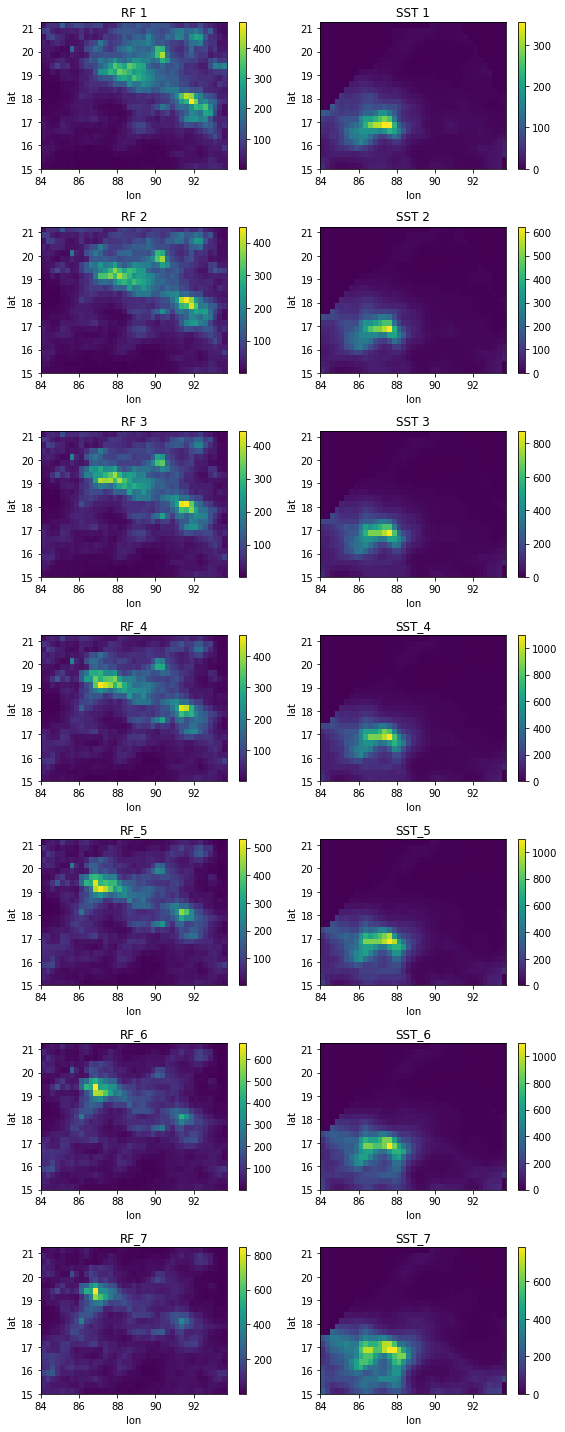

In [10]:
# Load multiple datasets
rf1,sst1 = Data_rf[0],Data_sst[0]
rf2,sst2 = Data_rf[1],Data_sst[1]
rf3,sst3 = Data_rf[2],Data_sst[2]
rf4,sst4 = Data_rf[3],Data_sst[3]
rf5,sst5 = Data_rf[4],Data_sst[4]
rf6,sst6 = Data_rf[5],Data_sst[5]
rf7,sst7 = Data_rf[6],Data_sst[6]

# Create subplots in a 7x2 layout
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(8, 20))

rf1.plot(ax=axs[0, 0])
axs[0, 0].set_title('RF 1')

rf2.plot(ax=axs[1, 0])
axs[1, 0].set_title('RF 2')

rf3.plot(ax=axs[2, 0])
axs[2, 0].set_title('RF 3')

rf4.plot(ax=axs[3, 0])
axs[3, 0].set_title('RF_4')

rf5.plot(ax=axs[4, 0])
axs[4, 0].set_title('RF_5')

rf6.plot(ax=axs[5, 0])
axs[5, 0].set_title('RF_6')

rf7.plot(ax=axs[6, 0])
axs[6, 0].set_title('RF_7')

sst1.plot(ax=axs[0, 1])
axs[0, 1].set_title('SST 1')

sst2.plot(ax=axs[1, 1])
axs[1, 1].set_title('SST 2')

sst3.plot(ax=axs[2, 1])
axs[2, 1].set_title('SST 3')

sst4.plot(ax=axs[3, 1])
axs[3, 1].set_title('SST_4')

sst5.plot(ax=axs[4, 1])
axs[4, 1].set_title('SST_5')

sst6.plot(ax=axs[5, 1])
axs[5, 1].set_title('SST_6')

sst7.plot(ax=axs[6, 1])
axs[6, 1].set_title('SST_7')

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.show()


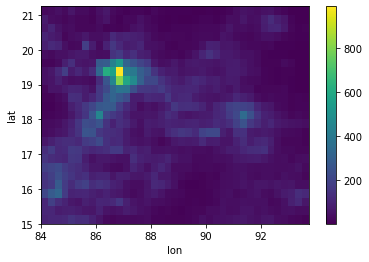

In [34]:
actual_day1 = xr.DataArray(y[0,:,:,0],dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
actual_day1.plot()

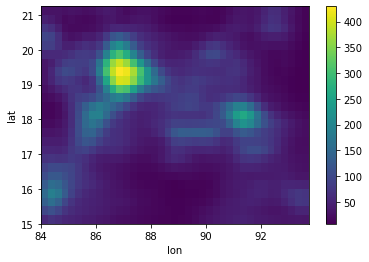

In [35]:
pred_day1 = xr.DataArray(pred[0,:,:,0],dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
pred_day1.plot()

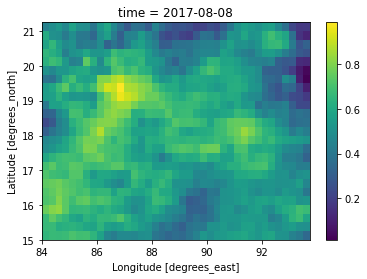

In [50]:

sequence = xr.open_dataarray(add_data+"FilteredrfBOB_0lag.nc")[-518:-508]
sequence = sequence.sel(time=slice("2017-08-01","2017-08-11"))
sequence = sequence.where(sequence.time.dt.month.isin([6,7,8,9]), drop=True)
max = sequence.max()
min = sequence.min()
# Max-min normalization
sequence = (sequence-min)/(max - min)

sequence[7].plot()
    


In [51]:
sequence = y[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 


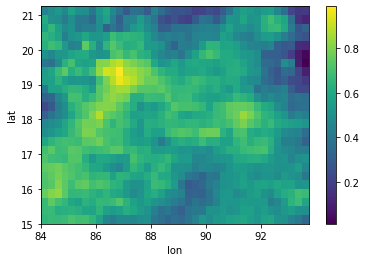

In [52]:
sequence.plot()

In [54]:
sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 


In [56]:
Day1 = sequence

In [58]:
lead_time = 0
channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

model_path = save_path + "ConvLstm_sst0rf_rf_0bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = y[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
Actual_d1 = sequence

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d1 = sequence


Adding channel 0 with shape: (4, 7, 1, 25, 39)
Adding channel 1 with shape: (4, 7, 1, 25, 39)
INPUT SHAPE -->  (4, 7, 2, 25, 39)
TARGET SHAPE -->  (4, 1, 25, 39)
1/1 [==============================] - 3s 3s/step


In [62]:
lead_time = 1
channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

model_path = save_path + "7in2out/ConvLstm_sst0rf_rf_1bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = y[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
Actual_d2 = sequence

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d2 = sequence


Adding channel 0 with shape: (3, 7, 1, 25, 39)
Adding channel 1 with shape: (3, 7, 1, 25, 39)
INPUT SHAPE -->  (3, 7, 2, 25, 39)
TARGET SHAPE -->  (3, 1, 25, 39)
1/1 [==============================] - 1s 815ms/step


In [64]:
lead_time = 2
channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

model_path = save_path + "7in3out/ConvLstm_sst0rf_rf_2bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = y[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
Actual_d3 = sequence

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d3 = sequence


Adding channel 0 with shape: (2, 7, 1, 25, 39)
Adding channel 1 with shape: (2, 7, 1, 25, 39)
INPUT SHAPE -->  (2, 7, 2, 25, 39)
TARGET SHAPE -->  (2, 1, 25, 39)
1/1 [==============================] - 1s 829ms/step


In [65]:
lead_time = 3
channels = ["FilteredrfBOB_0lag.nc","FilteredSSTBOB_0.nc"]
steps = 7

# Create input for the model
input = create_input(channels, steps)

# Preprocess target data
channel_data = xr.open_dataarray(add_data + "FilteredrfBOB_0lag.nc")
_, target = preprocess_data(channel_data, n_steps=steps, channels=channels[-1])
target = np.expand_dims(target, axis=1)

# Roll axes for input and target
x = np.rollaxis(input, 4, 2)
x = np.rollaxis(x, 4, 2)

y = np.rollaxis(target, 3, 1)
y = np.rollaxis(y, 3, 1)

# Assert that input and target shapes are consistent
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]


# Print shape of input and target
print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

# Delete original input and target variables to free up memory
del input
del target

model_path = save_path + "7in4out/ConvLstm_sst0rf_rf_3bob.h5"
model = tf.keras.models.load_model(model_path)
pred = model.predict(x)


sequence = y[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
Actual_d4 = sequence

sequence = pred[0,:,:,0]
valid_pts = np.where(sequence==sequence)
sequence[valid_pts] = np.power(sequence[valid_pts],1/7)
sequence[valid_pts] = np.log(sequence[valid_pts])
invalid_pts = np.where(sequence == 0)
sequence[invalid_pts] = np.nan

sequence = xr.DataArray(sequence,dims=( 'lat', 'lon'),coords={'lat': a.lat.data,'lon':a.lon.data})
#sequence = sequence*(max - min)+min 
pred_d4 = sequence


Adding channel 0 with shape: (1, 7, 1, 25, 39)
Adding channel 1 with shape: (1, 7, 1, 25, 39)
INPUT SHAPE -->  (1, 7, 2, 25, 39)
TARGET SHAPE -->  (1, 1, 25, 39)
1/1 [==============================] - 1s 885ms/step


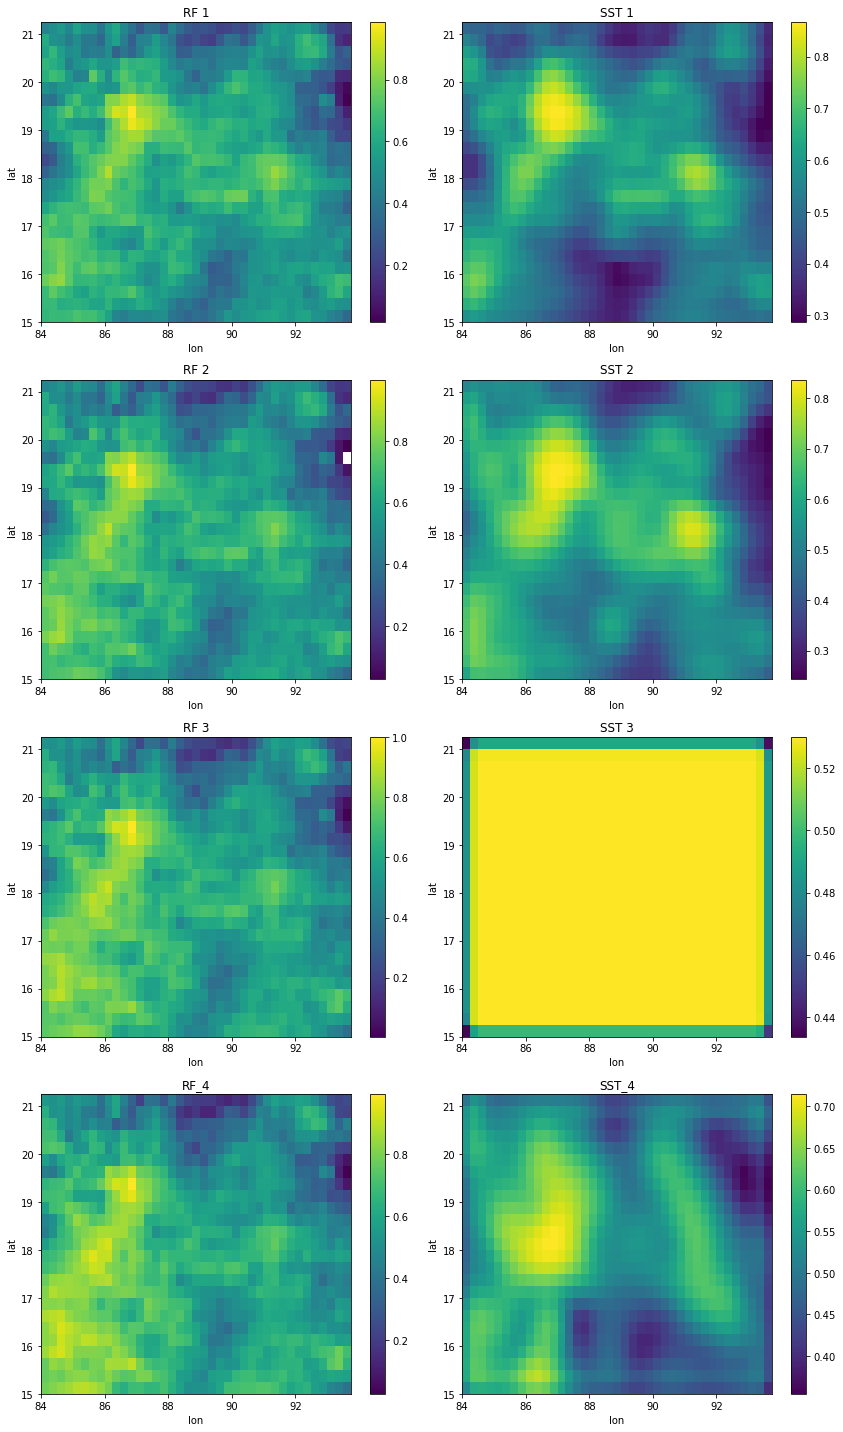

In [69]:
# Load multiple datasets
rf1,sst1 = Actual_d1,pred_d1
rf2,sst2 = Actual_d2,pred_d2
rf3,sst3 = Actual_d3,pred_d3
rf4,sst4 = Actual_d4,pred_d4

# Create subplots in a 7x2 layout
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))

rf1.plot(ax=axs[0, 0])
axs[0, 0].set_title('RF 1')

rf2.plot(ax=axs[1, 0])
axs[1, 0].set_title('RF 2')

rf3.plot(ax=axs[2, 0])
axs[2, 0].set_title('RF 3')

rf4.plot(ax=axs[3, 0])
axs[3, 0].set_title('RF_4')



sst1.plot(ax=axs[0, 1])
axs[0, 1].set_title('SST 1')

sst2.plot(ax=axs[1, 1])
axs[1, 1].set_title('SST 2')

sst3.plot(ax=axs[2, 1])
axs[2, 1].set_title('SST 3')

sst4.plot(ax=axs[3, 1])
axs[3, 1].set_title('SST_4')

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.show()


In [70]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
add_data = '/home/cccr/roxy/matin/MTech_project/data/'
# Open datasets
sst = xr.open_dataset(add_data + "MJJAS.nc")
sst40 = sst.sst.assign_coords({'time': sst.sst.time.dt.dayofyear})
sst40_time = sst40.time[27:]
sst1 = xr.open_dataset(add_data + "jjas40mean.nc")
da = xr.open_dataset(add_data + "Percentilejjas.nc")
Percentilejjas2 = xr.open_dataset(add_data + "Percentilejjas2.nc")


In [81]:
a = sst.sel(time=slice("2017-05-01","2017-09-30"))
a.sst[27:].assign_coords({'time':da.time[27:].dt.dayofyear})

<xarray.DataArray 'sst' (time: 126, lat: 100, lon: 200)>
[2520000 values with dtype=float32]
Coordinates:
  * time     (time) int64 148 149 150 151 152 153 ... 268 269 270 271 272 273
  * lon      (lon) float32 50.12 50.38 50.62 50.88 ... 99.12 99.38 99.62 99.88
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 24.12 24.38 24.62 24.88
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

In [90]:
sst40_time[:1].values

array([148])

In [91]:

# Initialize lists for storing data
frq_40_list = []
frq_40jjas_list = []
inten_40_list = []

# Loop over data to calculate frq_40, frq_40jjas, and inten_40
a = sst.sel(time=slice("2017-05-01","2017-09-30"))
dataset = a.sst[27:].assign_coords({'time':da.time[27:].dt.dayofyear})

change1 = dataset - Percentilejjas2
change2 = change1.__xarray_dataarray_variable__.rename('sst')
change = change2.assign_coords({'time':da.time[27:].dt.dayofyear})

logic1 = xr.where(change > 0, 1, change)
logic2 = xr.where(logic1 < 0, 0, logic1)
logic = logic2.assign_coords({'time':da.time[27:].dt.dayofyear})

l = []
for j in range(0, 122):
    five_days_sum = logic[j:j + 5].sum('time', skipna=False)
    l.append(xr.where(five_days_sum < 5, 0, five_days_sum).data)
five_xr = xr.DataArray(np.array(l), coords=[("time", logic[4:].time.data), ("lat", logic[4:].lat.data), ("lon", logic[4:].lon.data)])

five_xr_logic = xr.where(five_xr == 5, 1, five_xr)

m = []
for k in range(0, 122):
    a = five_xr_logic[k:k + 2].sum("time", skipna=False)
    m.append(xr.where(a > 1, 0, a).data)
five_xr_start = xr.DataArray(np.array(m), coords=[("time", logic[4:].time.data), ("lat", logic[4:].lat.data), ("lon", logic[4:].lon.data)])
frq_40jjas_list.extend(five_xr_start.data)
frq_40_list.append(five_xr_start.sum("time", skipna=False).data)
inten_40_list.append(xr.where(five_xr_logic == 1, change[4:], five_xr_logic).sum("time", skipna=False).data)

# Create xarray DataArrays for frq_40, frq_40jjas, and inten_40
inten_17 = xr.DataArray(np.array(inten_40_list), coords=[("time", sst40_time[:1].data), ("lat", logic.lat.data), ("lon", logic.lon.data)])
cum_intensity_17mon = inten_17.sum("time", skipna=False)

frq_17mon = xr.DataArray(np.array(frq_40_list), coords=[("time", sst40_time[:1].data), ("lat", logic.lat.data), ("lon", logic.lon.data)])


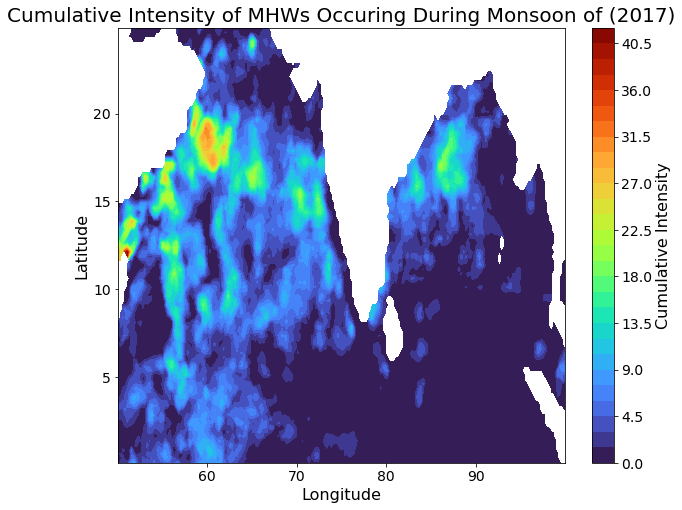

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('turbo')

contour_plot = ax.contourf(cum_intensity_17mon.lon, cum_intensity_17mon.lat, cum_intensity_17mon,
                           cmap=cmap, levels=30)

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('Cumulative Intensity', fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.set_title('Cumulative Intensity of MHWs Occuring During Monsoon of (2017)', fontsize=20)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)

ax.tick_params(labelsize=14)

plt.show()

#fig.savefig('MHW40yr_intens.png', bbox_inches='tight')


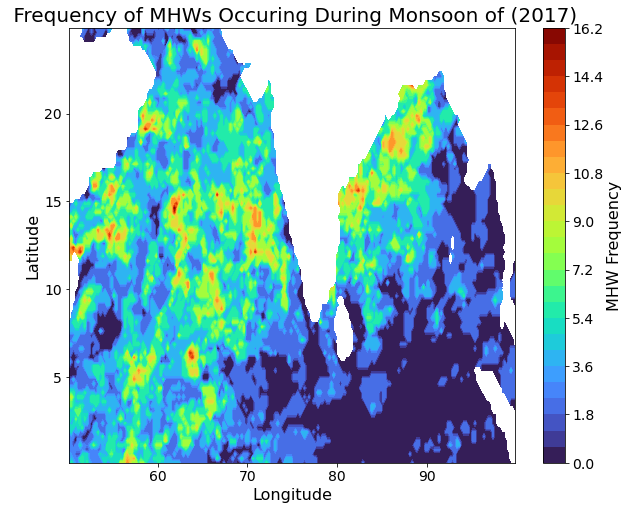

In [93]:
frq_40_sum = frq_17mon.sum("time",skipna=False)

fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.get_cmap('turbo')

contour_plot = ax.contourf(frq_40_sum.lon, frq_40_sum.lat, frq_40_sum,
                           cmap=cmap, levels=30)

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('MHW Frequency', fontsize=16)
cbar.ax.tick_params(labelsize=14)

ax.set_title(' Frequency of MHWs Occuring During Monsoon of (2017)', fontsize=20)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)

ax.tick_params(labelsize=14)
#fig.savefig('MHW40yr_Freq.png', bbox_inches='tight')
plt.show()
